### Данные:
Будем работать с датасетом [Boston Housing Prices](https://medium.com/@haydar_ai/learning-data-science-day-9-linear-regression-on-boston-housing-dataset-cd62a80775ef).

### Задание.
Будем решать задачу регрессии. Целевая переменная -- цена дома, признаки - различная информация о домохозяйстве. Для решения будем использовать линейную регрессию. Ваша задача - оценить качество решения в зависимости от количества объектов в обучающей выборке. Качество решения будем оценивать с помощью среднеквадратичной и среднеабсолютной ошибки, а так же [коэффициента детерминации $r^2$](http://scikit-learn.org/stable/modules/model_evaluation.html#r2-score-the-coefficient-of-determination). Также требуется оценить дисперсию данных функционалов в зависимости от числа объектов в обучающей выборке. 

*Обращаем ваше внимание, что для качественной оценки данных зависимостей эксперименты для каждого размера выборки стоит повторять многократно на различных случайных подвыборках.*

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import comb
from skimage import transform
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statistics import variance
from keras.datasets import boston_housing

(x_train, y_train), (x_test, y_test) = boston_housing.load_data()

/usr/local/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
class LinearRegressionTester:
    def __init__(self, x_train, y_train, x_test, y_test, num_of_tests):
        assert len(x_train) == len(y_train)
        assert len(x_test) == len(y_test)
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.num_of_tests = num_of_tests

    def test(self, size):
        assert size <= len(x_train)
        self.size = size
        test_results = self.run_tests()
        test_results = self.convert_test_results_to_dictionary(test_results)
        return (np.mean(test_results['mae']),
                variance(test_results['mae']),
                np.mean(test_results['mse']),
                variance(test_results['mse']),
                np.mean(test_results['r2']),
                variance(test_results['r2']))

    def run_tests(self):
        test_results = []
        for _ in range(self.num_of_tests):
            test_result = self.test_linear_regression()
            test_results.append(test_result)
        return test_results

    def test_linear_regression(self):
        (x_train_subset, y_train_subset) = self.get_random_train_subsets()
        
        lm = LinearRegression()
        lm.fit(x_train_subset, y_train_subset)

        y_pred = lm.predict(self.x_test)

        mae = mean_absolute_error(self.y_test, y_pred)
        mse = mean_squared_error(self.y_test, y_pred)
        r2 = r2_score(self.y_test, y_pred)

        return (mae, mse, r2)
    
    def convert_test_results_to_dictionary(self, lst):
        # https://stackoverflow.com/questions/28176949/convert-list-of-tuples-to-structured-numpy-array
        dt = np.dtype('float,float,float')
        dt.names = ['mae', 'mse', 'r2']
        return np.array(lst, dtype=dt)
    
    def get_random_train_subsets(self):
        # https://stackoverflow.com/questions/19485641/python-random-sample-of-two-arrays-but-matching-indices
        index = np.random.choice(np.arange(len(self.x_train)), self.size, replace=False)
        return (self.x_train[index], self.y_train[index])

In [9]:
class TestResultsPlotter:
    def __init__(self):
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif')
        plt.style.use(['dark_background'])
    
    def plot(self, test_results):
        self.test_results = self.convert_test_results_to_dict(test_results)
        fig, [mae, mse, r2] = plt.subplots(3, 1, figsize=(15, 25), constrained_layout=True)
        
        self.plot_test_result(mae, 'mae', 'mean absolute error')
        self.plot_test_result(mse, 'mse', 'mean square error')
        self.plot_test_result(r2, 'r2', '$R^2$ score')

    def plot_test_result(self, plt, name, title):
        test_result = self.test_results[name]
        test_result_variance = self.test_results[name + '_var']
        x = np.arange(50, 50 + len(test_result))
        plt.plot(x, test_result)
        plt.fill_between(x, 
                         test_result - test_result_variance, 
                         test_result + test_result_variance, 
                         color='gray', alpha=0.3)
        plt.set_title(title, fontsize=16)
        plt.axis('tight')
        plt.grid(True)
    
    def convert_test_results_to_dict(self, test_results):
        dt = np.dtype('float,float,float,float,float,float')
        dt.names = ['mae', 'mae_var', 'mse', 'mse_var', 'r2', 'r2_var']
        return np.array(test_results, dtype=dt)

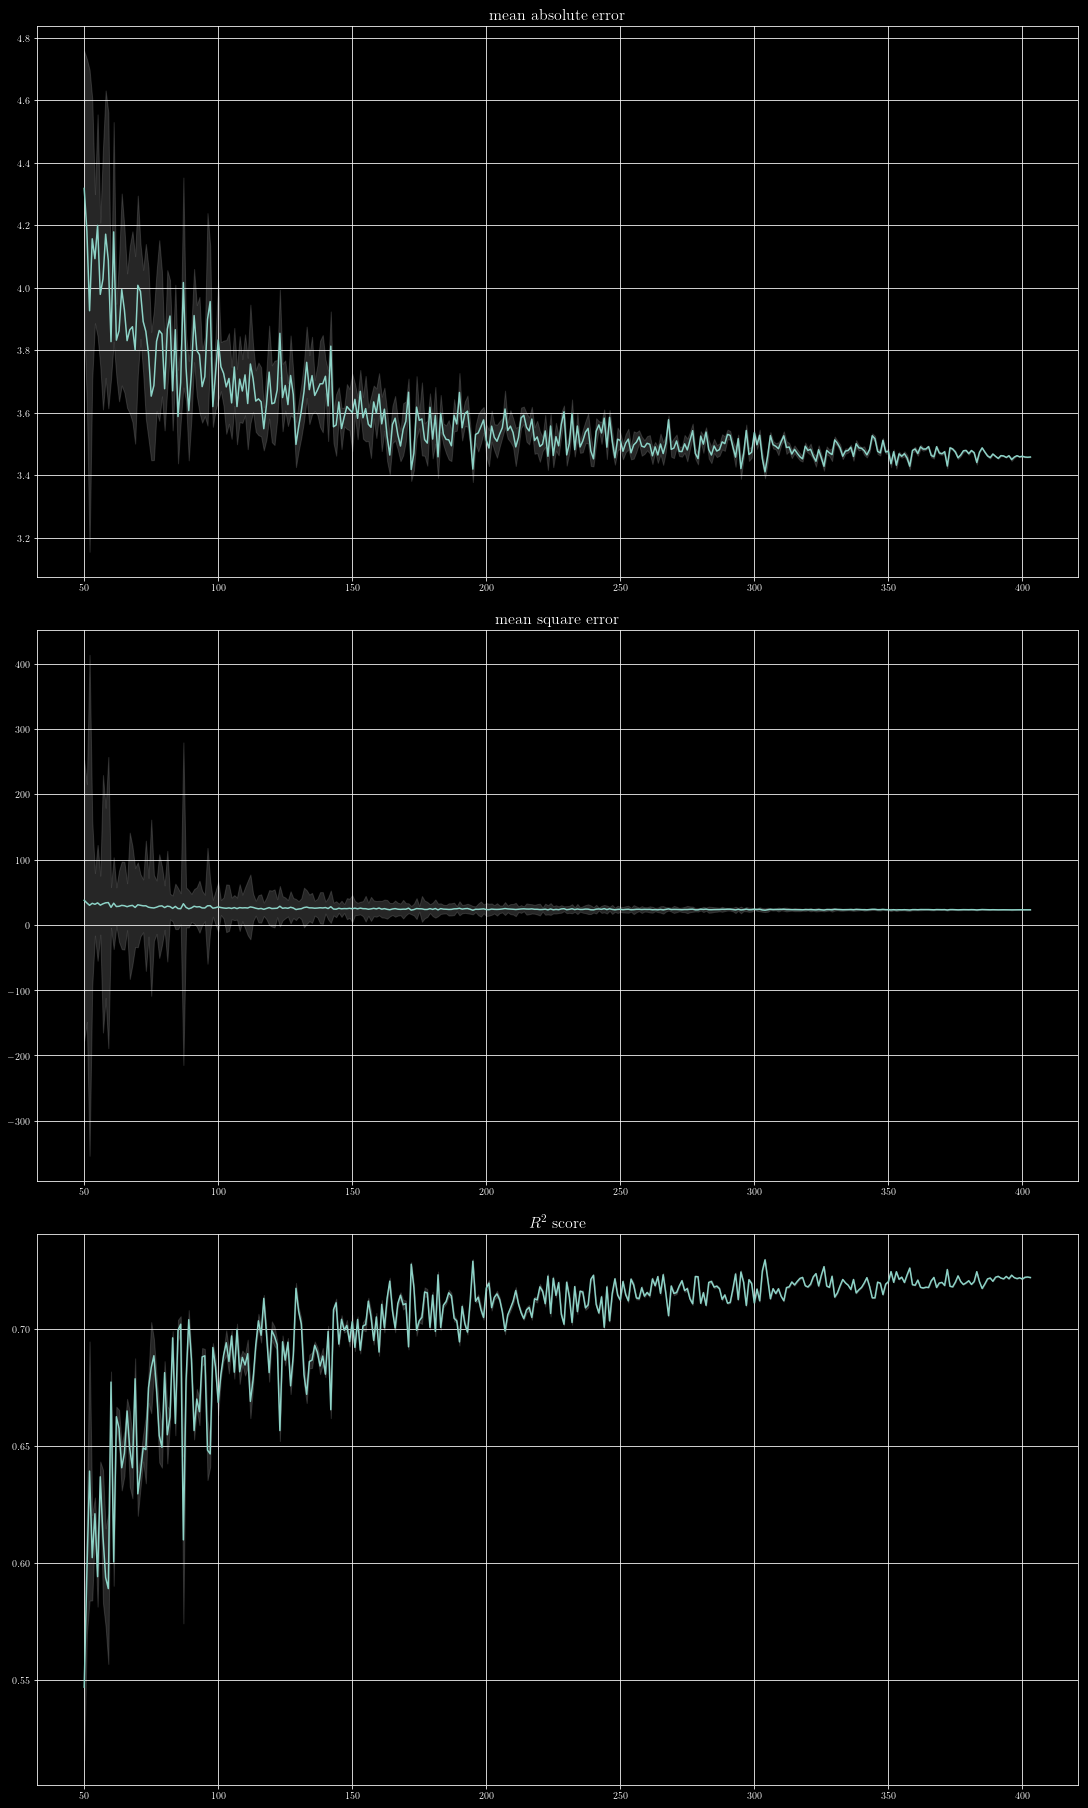

In [10]:
test_results = []
tester = LinearRegressionTester(x_train, y_train, x_test, y_test, 20)

for size in range(50, len(x_train)):
    test_results.append(tester.test(size))
    
plotter = TestResultsPlotter()
plotter.plot(test_results)

# Вывод
Из графиков видно, что точность предсказания растет при увеличении числа объектов в тренировочной выборке